In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
# data import funcs
os.chdir('/home/rv76/CCB/BioPlexPy/')
from BioPlexPy.data_import_funcs import getCorum
from BioPlexPy.data_import_funcs import getBioPlex

## [0] Environment Setup

setup for running 
- created virtual environment in conda 
> conda create -n CCB_BioPlexPy python=3.7
- installed **pandas**
> conda install -c anaconda pandas
- installed **requests**
> conda install -c anaconda requests
- installed **anndata**
> conda install anndata -c bioconda
- installed **jupyter notebook**
> conda install -c conda-forge notebook
- installed **networkx**
> pip install networkx[default]
- installed **biopython**
> conda install -c conda-forge biopython
- installed **nglview**

> conda install nglview -c conda-forge

> jupyter-nbextension enable nglview --py --sys-prefix

> jupyter-nbextension enable --py --sys-prefix widgetsnbextension

- installed **pypdb**
> pip install pypdb

### *Function*

[1] Get the set of UniProt IDs corresponding to a CORUM complex ID

In [10]:
import pandas as pd

def get_UniProts_from_CORUM(Corum_DF, Complex_ID):
    '''
    Retreive set of UniProt IDs corresponding to a CORUM complex ID.
    
    This function takes a CORUM complex ID and CORUM complex DataFrame
    and returns the corresponding UniProt IDs.

    Parameters
    ----------
    DataFrame of CORUM complexes : Pandas DataFrame
    Corum Complex ID: int

    Returns
    -------
    UniProt IDs
        A list of UniProt IDs for the CORUM complex specified.

    Examples
    --------
    >>> Corum_DF = getCorum('core', 'Human') # (1) Obtain CORUM complexes
    >>> UniProts_Arp_2_3 = get_UniProts_from_CORUM(Corum_DF, Complex_ID = 27) # (2) Get set of UniProt IDs for specified protein complex (Arp 2/3 complex ID: 27)
    '''
    # get UniProt IDs for each protein in the CORUM complex
    uniprot_IDs_list = Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,'subunits(UniProt IDs)'].values[0].split(';')
        
    return uniprot_IDs_list

### *Function*

[2] Get the set of PDB IDs corresponding to a set of UniProt IDs or a CORUM complex ID

In [16]:
import pandas as pd
import itertools
from collections import Counter

def get_PDB_from_UniProts(uniprot_IDs_list):
    '''
    Retreive PDB IDs for protein structures corresponding to set of UniProt IDs.
    
    This function takes a list of UniProt IDs and maps the corresponding UniProt IDs (from
    the UniProt IDs input or CORUM complex ID) to PDB IDs using the SIFTS project. Some 
    metadata for each PDB ID is pulled from PDB and stored in a DataFrame that is returned.

    Parameters
    ----------
    UniProt IDs : list (optional)

    Returns
    -------
    PDB IDs and associated metadata
        Pandas DataFrame of PDB IDs that map to the UniProt IDs input, or corresponding UniProt IDs from
        the CORUM complex specified.

    Examples
    --------
    >>> PDB_ID_Arp_2_3 = get_PDB_from_UniProts(['Q92747','O15144','P61158','P61160','O15145','P59998','O15511']) # (1) Get set of PDB IDs for list of UniProt IDs that correspond to Arp 2/3
    '''
    # get number of proteins in query
    num_proteins = len(uniprot_IDs_list)

    # Map from CORUM complex subunits given as UniProt IDs 
    # via [SIFTS](https://www.ebi.ac.uk/pdbe/docs/sifts/quick.html) to PDB structures:
    # "A summary of the UniProt to PDB mappings showing the UniProt accession followed by a semicolon-separated list of PDB four letter codes."
    uniprot_pdb_mapping_df = pd.read_csv("ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/uniprot_pdb.csv.gz", header = 1, sep = ',', compression = 'gzip')

    # set UniProt IDs as index
    uniprot_pdb_mapping_df.set_index('SP_PRIMARY', drop = True, inplace = True)

    # convert col PDB semicolon-separated list into Python list
    uniprot_pdb_mapping_df.loc[:,'PDB'] = [PDB_codes_i.split(';') for PDB_codes_i in uniprot_pdb_mapping_df.PDB]

    # get PDB IDs that map to each UniProt ID
    PDB_IDs_for_uniprot_dict = {}
    for uniprot_ID_i in uniprot_IDs_list:

        # check to see if UniProt ID exists in mapping
        if uniprot_ID_i in uniprot_pdb_mapping_df.index:

            # append to list of PDB IDs, take ALL PDB IDs in mapped list
            mapped_PDB_ID_i = uniprot_pdb_mapping_df.loc[uniprot_ID_i,:].values[0]

            # convert to uppercase
            mapped_PDB_ID_i = [PDB_ID.upper() for PDB_ID in mapped_PDB_ID_i]

            PDB_IDs_for_uniprot_dict[uniprot_ID_i] = mapped_PDB_ID_i

        else:
            print(f'WARNING: {uniprot_ID_i_complex_i} does not have any corresponding PDB IDs mapped.')

    # create dictionary of PDB IDs and store list of Uniprot IDs each one is mapped to
    unique_PDB_IDs = list(set(itertools.chain(*list(PDB_IDs_for_uniprot_dict.values())))) # flatten list of PDB IDs that mapped to UniProt IDs
    uniprot_IDs_list_for_PDB_dict = {}
    for PDB_ID in unique_PDB_IDs:

        uniprot_to_PDB_i = []
        for uniprot_ID in PDB_IDs_for_uniprot_dict.keys():
            if PDB_ID in PDB_IDs_for_uniprot_dict[uniprot_ID]:
                uniprot_to_PDB_i.append(uniprot_ID)

        uniprot_IDs_list_for_PDB_dict[PDB_ID] = uniprot_to_PDB_i

    uniprot_IDs_list_for_PDB_series = pd.Series(uniprot_IDs_list_for_PDB_dict)

    # if no PDB IDs mapped to UniProt IDs (empty list), raise warning
    if len(uniprot_IDs_list_for_PDB_series) == 0:
        print(f'WARNING: Could not map PDB ID to this CORUM complex ID or UniProt IDs.')
        complex_i_PDBs_df = None

    else:
        # iterate through PDB ID & retreive metadata
        PDB_protein_count = [] # stores number of polymer proteins for this structure
        PDB_deposit_date = [] # store the date of deposit for this structure
        PDB_citation_title = [] # store the title of the citation for this structure
        PDB_to_uniprot_map_list = [] # store list of UniProt IDs that mapped to each PDB ID
        for PDB_ID in uniprot_IDs_list_for_PDB_series.index:

            # retreive metadata for this structure from PDB
            PDB_structure_all_info = get_info(PDB_ID)
            PDB_protein_count.append(PDB_structure_all_info['rcsb_entry_info']['polymer_entity_count_protein'])
            PDB_deposit_date.append(pd.to_datetime(PDB_structure_all_info['rcsb_accession_info']['deposit_date']))
            PDB_citation_title.append(PDB_structure_all_info['rcsb_primary_citation']['title'])
            PDB_to_uniprot_map_list.append(uniprot_IDs_list_for_PDB_series[PDB_ID])

        # convert CORUM complex i - associated PDB IDs into DataFrame w/ # proteins & resolution
        UniProt_assoc_PDBs_df = pd.DataFrame(index = uniprot_IDs_list_for_PDB_series.index)
        UniProt_assoc_PDBs_df.loc[:,'num_proteins'] = PDB_protein_count
        UniProt_assoc_PDBs_df.loc[:,'deposit_date'] = PDB_deposit_date
        UniProt_assoc_PDBs_df.loc[:,'citation_title'] = PDB_citation_title
        UniProt_assoc_PDBs_df.loc[:,'UniProts_mapped_to_PDB'] = PDB_to_uniprot_map_list # the UniProt IDs that mapped to this PDB ID from SIFTS

        # column for number of proteins in PDB structure different from num proteins listed in CORUM complex or input by user
        UniProt_assoc_PDBs_df.loc[:,'num_proteins_diff_btwn_PDB_and_UniProts_input'] = abs(UniProt_assoc_PDBs_df.num_proteins - num_proteins)

        # pick PDB structure that has same number of proteins/chains as CORUM complex (or matches closest), then rank by most recent deposit date
        UniProt_assoc_PDBs_df.sort_values(by = ['num_proteins_diff_btwn_PDB_and_UniProts_input','deposit_date'], ascending = [True, False], inplace = True)
        
    return UniProt_assoc_PDBs_df

### *Function*

[3] Choose a PDB ID and get the chains that are physically close to eachother.

In [14]:
from Bio.PDB import *
import numpy as np
from scipy.spatial.distance import cdist

def get_interacting_chains_from_PDB(PDB_ID_structure_i, protein_structure_dir):
    '''
    Retreive chain pairs that are physically close to eachother from PDB structure.
    
    This function downloads the PDB structure that is specified from the input PDB ID
    into the input directory, then computes the pairwise distances between all atoms
    for each pair of chains in the structure. A list of chain pairs that are interacting 
    (have at least a pair of atoms < 6 angstroms apart) is returned.

    Parameters
    ----------
    PDB ID: str
    directory to store PDB file: str

    Returns
    -------
    Interacting Chains
        List of chain pairs from PDB structure that interact.

    Examples
    --------
    >>> interacting_chains_list = get_interacting_chains_from_PDB('6YW7', '/n/data1/hms/ccb/lab/projects/bioplex/BioPlexPy/protein_function_testing') # (1) Obtain list of interacting chains from 6YW7 structure
    '''
    # download structure from PDB
    pdbl = PDBList()
    PBD_file_path = pdbl.retrieve_pdb_file(PDB_ID_structure_i, pdir=protein_structure_dir, file_format='pdb', overwrite=True)

    # create a structure object
    parser = PDBParser()
    structure = parser.get_structure(PDB_ID_structure_i, PBD_file_path)

    model = structure[0]
    chain_IDs = [chain.get_id() for chain in model] # get a list of all chains

    # we want to test every pair of chains to see if they have any atoms that are < 6 angstroms in distance
    possible_chain_pairs = list(itertools.combinations(chain_IDs, 2))

    chain_pairs_direct_interaction = []
    # iterate through all chain pairs and check to see if any atoms are close
    for chain_i_id, chain_j_id in possible_chain_pairs:

        # get chain objects from models
        chain_i = model[chain_i_id]
        chain_j = model[chain_j_id]

        # get all atoms from each chain, 'A' stands for ATOM
        atom_list_i = Selection.unfold_entities(chain_i, "A")
        atom_list_j = Selection.unfold_entities(chain_j, "A")

        # get the coordinates for the atom in each chain
        atom_coords_i = [atom_list_i[k].coord for k in range(0,len(atom_list_i))]
        atom_coords_i = np.vstack(atom_coords_i)

        atom_coords_j = [atom_list_j[k].coord for k in range(0,len(atom_list_j))]
        atom_coords_j = np.vstack(atom_coords_j)

        # compute pairwise distances betweeen all atoms from different chains
        dists = cdist(atom_coords_i, atom_coords_j)

        # if a pair of atoms < 6 angstroms apart, store as interacting chains
        if np.sum(dists < 6) >= 1:
            chain_pairs_direct_interaction.append([chain_i_id, chain_j_id])
        
    return chain_pairs_direct_interaction

### *Functions*

[4] Modified from *https://github.com/PDBeurope/pdbe-api-training/blob/master/api_tutorials/5_PDB_to_UniProt_mappings_with_SIFTS.ipynb*; returns a mapping from **PDB chain ID** -> **Uniprot ID** for a given PDB ID.

In [15]:
import requests
import re

def make_request(url, mode, pdb_id):
    '''
    Make requests to PDBe API.
    
    This function can make GET and POST requests to the PDBe API.
    
    Parameters
    ----------
    url: str
    mode: str
    pdb_id: str
    
    Returns
    -------
        JSON or None
    '''
    if mode == "get":
        response = requests.get(url=url+pdb_id)
    elif mode == "post":
        response = requests.post(url, data=pdb_id)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))
    
    return None

def get_mappings_data(pdb_id):
    '''
    Get mappings data for PDB ID.
    
    This function will retreive the mappings data from
    the PDBe API using the make_request() function.
    
    Parameters
    ----------
    pdb_id: str
    
    Returns
    -------
        JSON of mappings or None
    '''
    # specify URL
    base_url = "https://www.ebi.ac.uk/pdbe/"
    api_base = base_url + "api/"
    uniprot_mapping_url = api_base + 'mappings/uniprot/'
    
    # Check if the provided PDB id is valid
    # There is no point in making an API call
    # with bad PDB ids
    if not re.match("[0-9][A-Za-z][A-Za-z0-9]{2}", pdb_id):
        print("Invalid PDB id")
        return None
    
    # GET the mappings data
    mappings_data = make_request(uniprot_mapping_url, "get", pdb_id)
    
    # Check if there is data
    if not mappings_data:
        print("No data found")
        return None
    
    return mappings_data

def list_uniprot_pdb_mappings(pdb_id):
    '''
    Get PDB chain to UniProt mappings.
    
    This function retrieves PDB > UniProt mappings using the 
    get_mappings_data() function, the parses the resulting 
    JSON to construct a dictionary where each key is a chain
    from the PDB structure, and the corresponding value for
    each is a list of UniProt IDs that map to the chain from 
    the SIFTS project.
    
    Parameters
    ----------
    pdb_id: str
    
    Returns
    -------
    Chain to UniProt Map
        Dictionary of PDB ID chain to UniProt ID mappings
        
    Examples
    --------
    >>> chain_to_UniProt_mapping_dict = list_uniprot_pdb_mappings('6YW7') # (1) Obtain a mapping of PDB ID 6YW7 chains to UniProt IDs
    '''
    # convert to PDB id to lower case
    pdb_id = pdb_id.lower()
    
    # Getting the mappings data
    mappings_data = get_mappings_data(pdb_id)
    
    # If there is no data, return None
    if not mappings_data:
        return None
    
    # dictionary that stores UniProt > chain id mappings
    uniprot_chain_mapping_dict = {}
    
    uniprot = mappings_data[pdb_id]["UniProt"]
    for uniprot_id in uniprot.keys():
        mappings = uniprot[uniprot_id]["mappings"]
        
        # store the chain ids that correspond to this UniProt ID
        uniprot_chain_mapping_dict[uniprot_id] = []
        
        for mapping in mappings:
            entity_id = mapping["entity_id"]
            
            chain_id = mapping["chain_id"]
            uniprot_chain_mapping_dict[uniprot_id].append(chain_id)
            
            pdb_start = mapping["start"]["residue_number"]
            pdb_end = mapping["end"]["residue_number"]
            uniprot_start = mapping["unp_start"]
            uniprot_end = mapping["unp_end"]
        
    # "flip" the uniprot > pdb chain mapping
    chain_IDs = list(set([item for sublist in uniprot_chain_mapping_dict.values() for item in sublist])) # get all unique chain IDs

    chain_uniprot_mapping_dict = {}
    # iterate through every chain ID
    for chain_i in chain_IDs:

        # iterate through every uniprot ID and check to see if chain ID is mapped
        chain_uniprot_mapping_dict[chain_i] = []
        for uniprot_i in uniprot_chain_mapping_dict.keys():
            if chain_i in uniprot_chain_mapping_dict[uniprot_i]:
                chain_uniprot_mapping_dict[chain_i].append(uniprot_i)
                
    return chain_uniprot_mapping_dict

### *Function*

[5] Take the *interacting chains* and *chain > uniprot mapping* and returns the interacting uniprot IDs.

In [16]:
def PDB_chains_to_uniprot(interacting_chains_list, chain_to_UniProt_mapping_dict):
    '''
    Get interacting chains from PDB structure mapped to UniProt IDs.
    
    This function takes the list of interacting chains from function
    get_interacting_chains_from_PDB() and the chain to UniProt mappings
    from function list_uniprot_pdb_mappings() and returns a list of 
    interacting chains using UniProt IDs.
    
    Parameters
    ----------
    Interacting Chains: list
    Chain to UniProt Map: dict
    
    Returns
    -------
    Interacting Chains
        List of interacting chains using UniProt IDs
    
    Examples
    --------
    >>> interacting_chains_list = get_interacting_chains_from_PDB('6YW7', '/n/data1/hms/ccb/lab/projects/bioplex/BioPlexPy/protein_function_testing') # (1) Obtain list of interacting chains from 6YW7 structure
    >>> chain_to_UniProt_mapping_dict = list_uniprot_pdb_mappings('6YW7') # (2) Obtain a mapping of PDB ID 6YW7 chains to UniProt IDs
    >>> interacting_UniProt_IDs = PDB_chains_to_uniprot(interacting_chains_list, chain_to_UniProt_mapping_dict) # (3) Obtain list of interacting chains from 6YW7 structure using UniProt IDs 
    '''
    interacting_UniProt_IDs = []
    for interacting_chain_pair_i in interacting_chains_list:

        # get UniProt IDs that map to each chain ID
        chain_i_UniProts = chain_to_UniProt_mapping_dict[interacting_chain_pair_i[0]]
        chain_j_UniProts = chain_to_UniProt_mapping_dict[interacting_chain_pair_i[1]]

        # store every pair of UniProt IDs that correspond to the interacting chains
        for chain_i_UniProt_ID in chain_i_UniProts:
            for chain_j_UniProt_ID in chain_j_UniProts:
                interacting_UniProt_IDs.append([chain_i_UniProt_ID,chain_j_UniProt_ID])
                
    return interacting_UniProt_IDs

### *Function*

[6] Visualize *interacting chains* as a network.

In [17]:
import numpy as np
import itertools
import networkx as nx

def display_PDB_network_for_complex(ax, chain_to_UniProt_mapping_dict, interacting_UniProt_IDs, node_size, edge_width, node_font_size=10):
    '''
    Display network of interacting chains.
    
    This function displays a complete network in which nodes represent the 
    proteins in a specified PDB structure, and edges represent chains in that
    structure, using NetworkX. Edges that are classified as interacting
    (are < 6 angstroms apart) are colored black.

    Parameters
    ----------
    ax object to draw on: Matplotlib Axes
    Mapping of Chains to UniProt IDs: dictionary
    List of Interacting Chains: list
    Size of Nodes in Network: int
    Width of Edges in Network: float
    Size of font for Node Labels: int (optional)

    Returns
    -------
    Node Positions
        Dictionary of Node Positions in NetworkX layout
    Interacting Network Edges
        List of Edges for Interacting Nodes
    Number of Network Edges
        Float of the Number of Possible Interacting Edges

    Examples
    --------
    >>> interacting_chains_list = get_interacting_chains_from_PDB('6YW7', '/n/data1/hms/ccb/lab/projects/bioplex/BioPlexPy/protein_function_testing') # (1) Obtain list of interacting chains from 6YW7 structure
    >>> chain_to_UniProt_mapping_dict = list_uniprot_pdb_mappings('6YW7') # (2) Obtain a mapping of PDB ID 6YW7 chains to UniProt IDs
    >>> interacting_UniProt_IDs = PDB_chains_to_uniprot(interacting_chains_list, chain_to_UniProt_mapping_dict) # (3) Obtain list of interacting chains from 6YW7 structure using UniProt IDs
    >>> fig, ax = plt.subplots() # (4) create figure and axis objects to draw on
    >>> node_layout_pdb, edges_list_pdb, num_possible_edges_pdb = display_PDB_network_for_complex(ax, interacting_UniProt_IDs, 2300, 3.5) # (5) Visualize interacting chains using Uniprot IDs
    '''
    # create connected graph from all uniprot IDs
    chain_uniprot_IDs = [chain_uniprot_i[0] for chain_uniprot_i in chain_to_UniProt_mapping_dict.values()]

    # create a graph from the nodes/genes of this complex structure
    pdb_structure_i_G = nx.Graph()
    pdb_structure_i_G.add_nodes_from(chain_uniprot_IDs)

    # iterate over physical interactions and add edges
    for chain_pair_interacting in interacting_UniProt_IDs:
        pdb_structure_i_G.add_edge(chain_pair_interacting[0], chain_pair_interacting[1])

    # create a complete graph from the nodes of complex graph to add in all "background" edges (edges detected with AP-MS will be colored over)
    # position will be the same for both graphs since nodes are the same
    pdb_structure_i_G_complete = nx.Graph()
    pdb_structure_i_G_complete.add_nodes_from(pdb_structure_i_G.nodes)
    pdb_structure_i_G_complete.add_edges_from(itertools.combinations(pdb_structure_i_G.nodes, 2))

    # set position of nodes w/ circular layout
    pos = nx.circular_layout(pdb_structure_i_G)

    # construct edges for COMPLETE graph for "background" edges
    edges_complete = nx.draw_networkx_edges(pdb_structure_i_G_complete, pos, width = edge_width, alpha = 0.25, ax = ax)
    edges_complete.set_edgecolor("xkcd:grey")

    # construct edges
    edges = nx.draw_networkx_edges(pdb_structure_i_G, pos, width = edge_width, ax = ax)
    edges.set_edgecolor('xkcd:blue')

    # construct nodes
    nodes = nx.draw_networkx_nodes(pdb_structure_i_G, pos, node_size = node_size, node_color = 'xkcd:black', ax = ax)
    nodes.set_edgecolor("xkcd:black")
    nodes.set_linewidth(1.5)
    nx.draw_networkx_labels(pdb_structure_i_G, pos, font_size = node_font_size, font_weight = 'bold', font_color = 'xkcd:white', ax = ax)

    # return node position layout, list of edges detected, number of possible edges
    return [pos, pdb_structure_i_G.edges, float(len(pdb_structure_i_G_complete.edges))]

### *Function*

[7] visualize corresponding *BioPlex PPI* data as a network.

In [18]:
import numpy as np
import itertools
import networkx as nx

def display_PPI_network_match_PDB(ax, chain_to_UniProt_mapping_dict, interacting_UniProt_IDs, bp_PPI_df, node_pos, node_size, edge_width, node_font_size=10, bait_node_color='xkcd:red', prey_node_color='xkcd:rose pink', AP_MS_edge_color='xkcd:red'):
    '''
    Display network of BioPlex PPIs for a set of interacting UniProt IDs.
    
    This function displays a complete network in which nodes represent the 
    proteins in a specified PDB structure, and edges represent chains in that
    structure, using NetworkX. Edges that are classified as interacting from
    BioPlex PPI data (detected through AP-MS) are colored darker.

    Parameters
    ----------
    ax object to draw on: Matplotlib Axes
    Mapping of Chains to UniProt IDs: dictionary
    List of Interacting Chains: list
    DataFrame of PPIs : Pandas DataFrame
    Networkx Position of Nodes: dict
    Size of Nodes in Network: int
    Width of Edges in Network: float
    Size of font for Node Labels: int (optional)
    Color of Nodes targeted as baits: str (optional)
    Color of Nodes detected as preys only: str (optional)
    Color of Edges observed via AP-MS from PPI data: str (optional)

    Returns
    -------
    Interacting Network Edges
        List of Edges for Interacting Nodes
    Number of Network Edges
        Float of the Number of Possible Interacting Edges

    Examples
    --------
    >>> interacting_chains_list = get_interacting_chains_from_PDB('6YW7', '/n/data1/hms/ccb/lab/projects/bioplex/BioPlexPy/protein_function_testing') # (1) Obtain list of interacting chains from 6YW7 structure
    >>> chain_to_UniProt_mapping_dict = list_uniprot_pdb_mappings('6YW7') # (2) Obtain a mapping of PDB ID 6YW7 chains to UniProt IDs
    >>> interacting_UniProt_IDs = PDB_chains_to_uniprot(interacting_chains_list, chain_to_UniProt_mapping_dict) # (3) Obtain list of interacting chains from 6YW7 structure using UniProt IDs
    >>> fig, ax1 = plt.subplots() # (4) create figure and axis objects to draw on
    >>> node_layout_pdb, edges_list_pdb, num_possible_edges_pdb = display_PDB_network_for_complex(ax1, interacting_UniProt_IDs, 2300, 3.5) # (5) Visualize interacting chains using Uniprot IDs
    >>> bp_PPI_df = getBioPlex('293T', '3.0') # (6) Get BioPlex PPI data
    >>> fig, ax2 = plt.subplots() # (7) create figure and axis objects to draw on
    >>> edges_list_bp, num_possible_edges_bp = display_PPI_network_match_PDB(ax2, interacting_UniProt_IDs, bp_PPI_df, node_layout_pdb, 2300, 3.5) # (8) Visualize BioPlex PPI interactions using layout from interacting chains
    '''
    # create connected graph from all uniprot IDs
    chain_uniprot_IDs = [chain_uniprot_i[0] for chain_uniprot_i in chain_to_UniProt_mapping_dict.values()]
    
    # filter BioPlex PPI dataframe to include only interactions where both genes are found in complex
    structure_uniprots_i_PPI_filter = []
    for uniprot_A, uniprot_B in zip(bp_PPI_df.UniprotA, bp_PPI_df.UniprotB):

        # check for isoform IDs and adjust
        if '-' in uniprot_A:
            uniprot_A = uniprot_A.split('-')[0]
        if '-' in uniprot_B:
            uniprot_B = uniprot_B.split('-')[0]

        # check to see if both gene symbols for this interaction are genes in complex
        if (uniprot_A in chain_uniprot_IDs) and (uniprot_B in chain_uniprot_IDs):
            structure_uniprots_i_PPI_filter.append(True)
        else:
            structure_uniprots_i_PPI_filter.append(False)

    structure_uniprots_i_PPI_filter = np.array(structure_uniprots_i_PPI_filter)
    bp_structure_i_df = bp_PPI_df[structure_uniprots_i_PPI_filter] # use filter to subset bp PPI dataframe
    bp_structure_i_df.reset_index(inplace = True, drop = True) # reset index

    # reconstruct UniprotA/UniprotB columns without '-' isoform id
    UniprotA_new = []
    UniprotB_new = []
    for UniprotA, UniprotB in zip(bp_structure_i_df.UniprotA, bp_structure_i_df.UniprotB):

        if '-' in UniprotA:
            UniprotA_new.append(UniprotA.split('-')[0])
        else:
            UniprotA_new.append(UniprotA)

        if '-' in UniprotB:
            UniprotB_new.append(UniprotB.split('-')[0])
        else:
            UniprotB_new.append(UniprotB)

    # update columns for Uniprot source & Uniprot target to exclude isoform '-' ID
    bp_structure_i_df.loc[:,'UniprotA'] = UniprotA_new
    bp_structure_i_df.loc[:,'UniprotB'] = UniprotB_new

    # subset PPI dataframe to the cols we need to construct graph
    bp_structure_i_df = bp_structure_i_df.loc[:,['UniprotA','UniprotB','SymbolA','SymbolB']]

    # create a graph from the nodes/genes of specified complex
    bp_structure_i_G = nx.Graph()
    bp_structure_i_G.add_nodes_from(chain_uniprot_IDs)

    # iterate over AP-MS interactions in PPI df and add edges
    for source, target in zip(bp_structure_i_df.UniprotA, bp_structure_i_df.UniprotB):
        bp_structure_i_G.add_edge(source, target)

    # get a list of genes that were identifed as "baits" and "preys" for coloring nodes
    bp_structure_i_baits = list(set(bp_structure_i_df.UniprotA))
    bp_structure_i_preys = list(set(bp_structure_i_df.UniprotB))

    # color nodes according to whether they were present among "baits" & "preys", just "baits", just "preys" or not detected in PPI data for this structure
    node_color_map = []
    for node_i_uniprot in bp_structure_i_G.nodes:

        # gene is present among baits & preys for the PPIs detected in this structure
        if (node_i_uniprot in bp_structure_i_baits) and (node_i_uniprot in bp_structure_i_preys):
            node_color_map.append(bait_node_color)

        # gene is present among baits but NOT preys for the PPIs detected in this structure
        elif (node_i_uniprot in bp_structure_i_baits) and (node_i_uniprot not in bp_structure_i_preys):
            node_color_map.append(bait_node_color)

        # gene is NOT present among baits but is present among preys for the PPIs detected in this structure
        elif (node_i_uniprot not in bp_structure_i_baits) and (node_i_uniprot in bp_structure_i_preys):
            node_color_map.append(prey_node_color)

        # gene is NOT present among baits and is NOT present among preys for the PPIs detected in this complex
        elif (node_i_uniprot not in bp_structure_i_baits) and (node_i_uniprot not in bp_structure_i_preys):
            node_color_map.append('0.7')
            
    # can use the complete graph from the pdb direct interaction graph since they have the same nodes
    # create a complete graph from the nodes of complex graph to add in all "background" edges (edges detected with AP-MS will be colored over)
    # position will be the same for both graphs since nodes are the same
    bp_structure_i_G_complete = nx.Graph()
    bp_structure_i_G_complete.add_nodes_from(bp_structure_i_G.nodes)
    bp_structure_i_G_complete.add_edges_from(itertools.combinations(bp_structure_i_G.nodes, 2))

    # construct edges for COMPLETE graph for "background" edges
    edges_complete = nx.draw_networkx_edges(bp_structure_i_G_complete, node_pos, width = edge_width, alpha = 0.25, ax = ax)
    edges_complete.set_edgecolor("xkcd:grey")

    # construct edges
    edges = nx.draw_networkx_edges(bp_structure_i_G, node_pos, width = edge_width, ax = ax)
    edges.set_edgecolor(AP_MS_edge_color)

    # construct nodes
    nodes = nx.draw_networkx_nodes(bp_structure_i_G, node_pos, node_size = node_size, node_color = node_color_map, ax = ax)
    nodes.set_edgecolor("xkcd:black")
    nodes.set_linewidth(1.5)
    nx.draw_networkx_labels(bp_structure_i_G, node_pos, font_size = node_font_size, font_weight = 'bold', font_color = 'xkcd:white', ax = ax)

    # return node position layout, list of edges detected, number of possible edges
    return [bp_structure_i_G.edges, float(len(bp_structure_i_G_complete.edges))]

### Example 1: *Arp 2/3 complex*

[1] Get the set of UniProt IDs corresponding to a CORUM complex ID

In [13]:
Corum_DF = getCorum('core', 'Human') # (1) Obtain CORUM complexes
UniProts_Arp_2_3 = get_UniProts_from_CORUM(Corum_DF = Corum_DF, Complex_ID = 27) # (2) Get set of UniProt IDs for specified protein complex (Arp 2/3 complex ID: 27)

In [25]:
print(UniProts_Arp_2_3)

['O15143', 'O15144', 'O15145', 'O15511', 'P59998', 'P61158', 'P61160']


[2] Get the set of PDB IDs corresponding to a *set of UniProt IDs*

In [17]:
PDB_IDs_df = get_PDB_from_UniProts(UniProts_Arp_2_3)

In [18]:
PDB_IDs_df

,num_proteins,deposit_date,citation_title,UniProts_mapped_to_PDB,num_proteins_diff_btwn_PDB_and_UniProts_input
6YW6,7,2020-04-29 00:00:00+00:00,Cryo-EM of human Arp2/3 complexes provides str...,"[O15143, O15144, O15145, P59998, P61158, P61160]",0
6YW7,7,2020-04-29 00:00:00+00:00,Cryo-EM of human Arp2/3 complexes provides str...,"[O15144, O15145, O15511, P59998, P61158, P61160]",0
6UHC,8,2019-09-27 00:00:00+00:00,Cryo-EM structure of NPF-bound human Arp2/3 co...,"[O15143, O15144, O15145, O15511, P59998, P6115...",1


[3] Choose a PDB ID and get the chains that are physically close to eachother.

In [52]:
PDB_ID = '6YW7'

In [53]:
protein_structure_dir = '/n/data1/hms/ccb/lab/projects/bioplex/BioPlexPy/protein_function_testing'
interacting_chains_list = get_interacting_chains_from_PDB(PDB_ID, protein_structure_dir)

In [54]:
interacting_chains_list

[['A', 'D'],
 ['A', 'E'],
 ['A', 'B'],
 ['D', 'F'],
 ['B', 'F'],
 ['B', 'G'],
 ['F', 'G'],
 ['F', 'C'],
 ['G', 'C']]

[4] Modified from *https://github.com/PDBeurope/pdbe-api-training/blob/master/api_tutorials/5_PDB_to_UniProt_mappings_with_SIFTS.ipynb*; returns a mapping from **PDB chain ID** -> **Uniprot ID** for a given PDB ID.

In [55]:
chain_to_UniProt_mapping_dict = list_uniprot_pdb_mappings(PDB_ID)

In [56]:
chain_to_UniProt_mapping_dict

{'F': ['P59998'],
 'C': ['Q92747'],
 'A': ['P61158'],
 'B': ['P61160'],
 'D': ['O15144'],
 'E': ['O15145'],
 'G': ['O15511']}

[5] Take the *interacting chains* and *chain > uniprot mapping* and returns the interacting uniprot IDs.

In [57]:
interacting_UniProt_IDs = PDB_chains_to_uniprot(interacting_chains_list, chain_to_UniProt_mapping_dict)

In [58]:
interacting_UniProt_IDs

[['P61158', 'O15144'],
 ['P61158', 'O15145'],
 ['P61158', 'P61160'],
 ['O15144', 'P59998'],
 ['P61160', 'P59998'],
 ['P61160', 'O15511'],
 ['P59998', 'O15511'],
 ['P59998', 'Q92747'],
 ['O15511', 'Q92747']]

[6-7] Visualize *interacting chains* and corresponding *BioPlex PPI* data as networks.

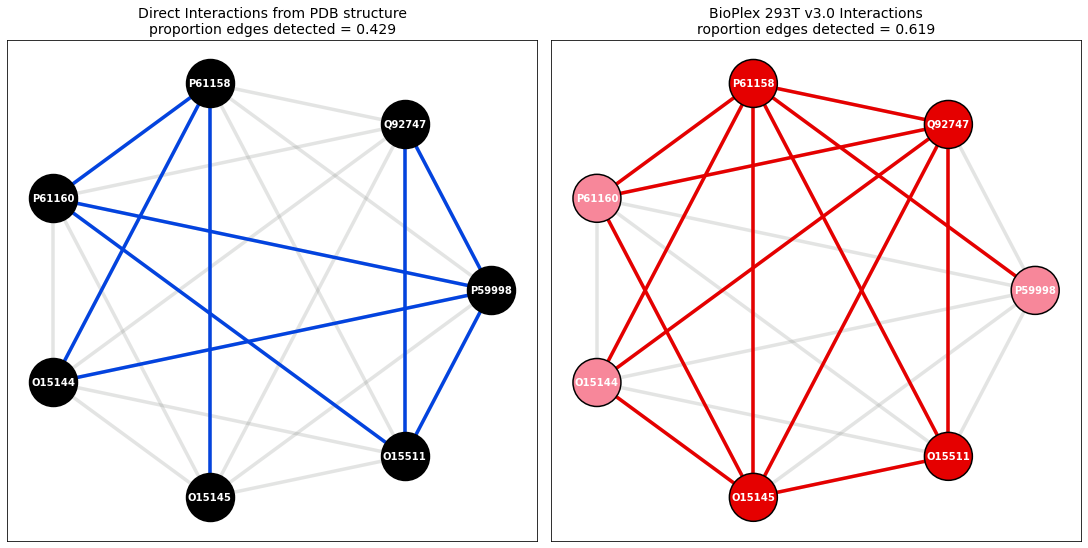

In [59]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig) # define 2 columns since we'll have two networks
spec.update(wspace=0.025) # set the spacing between axes

# chain/uniprot physical interaction network
ax1 = fig.add_subplot(spec[0])
node_layout_pdb, edges_list_pdb, num_possible_edges_pdb = display_PDB_network_for_complex(ax1, chain_to_UniProt_mapping_dict, interacting_UniProt_IDs, 2300, 3.5)
prop_edges_pdb = round(float(len(edges_list_pdb)) / num_possible_edges_pdb, 3)

# chain/uniprot PPI interaction network
ax2 = fig.add_subplot(spec[1])
bp_PPI_df = getBioPlex('293T', '3.0')
edges_list_bp, num_possible_edges_bp = display_PPI_network_match_PDB(ax2, chain_to_UniProt_mapping_dict, interacting_UniProt_IDs, bp_PPI_df, node_layout_pdb, 2300, 3.5)
prop_edges_bp = round(float(len(edges_list_bp)) / num_possible_edges_bp, 3)

# set titles
ax1.set_title(f'Direct Interactions from PDB structure\nproportion edges detected = {prop_edges_pdb}', color = 'black', fontsize = 14) # set title
ax2.set_title(f'BioPlex 293T v3.0 Interactions\nroportion edges detected = {prop_edges_bp}', color = 'black', fontsize = 14) # set title

fig = plt.gcf()
fig.set_size_inches(15, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_PDB_interaction_VS_293T_3.0_Arp_2_3-complex.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

Find the edges that are detected in both networks.

In [60]:
overlapping_edges_list = list(set(edges_list_pdb).intersection(set(edges_list_bp)))
overlapping_edges_list

[('Q92747', 'O15511'),
 ('P61158', 'O15144'),
 ('P61158', 'O15145'),
 ('P61158', 'P61160')]

Calculate proportion of edges that are detected in both networks.

In [61]:
round(float(len(overlapping_edges_list)) / num_possible_edges_pdb, 3)

0.19

### Example 2: *TFIIH Complex*

[1] Get the set of UniProt IDs corresponding to a CORUM complex ID

In [19]:
Corum_DF = getCorum('core', 'Human') # (1) Obtain CORUM complexes
UniProts_TFIIH = get_UniProts_from_CORUM(Corum_DF = Corum_DF, Complex_ID = 107) # (2) Get set of UniProt IDs for specified protein complex (TFIIH complex ID: 107)

In [24]:
print(UniProts_TFIIH)

['P18074', 'P19447', 'P32780', 'P50613', 'P51946', 'P51948', 'Q13888', 'Q13889', 'Q92759']


[2] Get the set of PDB IDs corresponding to a *set of UniProt IDs*

In [21]:
PDB_IDs_df = get_PDB_from_UniProts(UniProts_TFIIH)

In [23]:
PDB_IDs_df.head()

,num_proteins,deposit_date,citation_title,UniProts_mapped_to_PDB,num_proteins_diff_btwn_PDB_and_UniProts_input
7AD8,8,2020-09-14 00:00:00+00:00,The TFIIH subunits p44/p62 act as a damage sen...,"[P18074, P19447, P32780, Q13888, Q13889, Q92759]",1
6O9M,8,2019-03-14 00:00:00+00:00,Transcription preinitiation complex structure ...,"[P18074, P19447, P32780, P51948, Q13888, Q1388...",1
6NMI,8,2019-01-10 00:00:00+00:00,The complete structure of the human TFIIH core...,"[P18074, P19447, P32780, P51948, Q13888, Q1388...",1
5OF4,10,2017-07-10 00:00:00+00:00,The cryo-electron microscopy structure of huma...,"[P18074, P19447, Q13888, Q13889, Q92759]",1
7NVX,11,2021-03-16 00:00:00+00:00,Structures of mammalian RNA polymerase II pre-...,"[P18074, P19447, P32780, P51948, Q13888, Q1388...",2


[3] Choose a PDB ID and get the chains that are physically close to eachother.

In [66]:
PDB_ID = '6NMI'

In [67]:
protein_structure_dir = '/n/data1/hms/ccb/lab/projects/bioplex/BioPlexPy/protein_function_testing'
interacting_chains_list = get_interacting_chains_from_PDB(PDB_ID, protein_structure_dir)

In [68]:
interacting_chains_list

[['A', 'B'],
 ['A', 'D'],
 ['A', 'E'],
 ['A', 'G'],
 ['A', 'H'],
 ['B', 'C'],
 ['B', 'E'],
 ['B', 'H'],
 ['C', 'D'],
 ['C', 'E'],
 ['C', 'F'],
 ['D', 'F'],
 ['D', 'G'],
 ['E', 'F']]

[4] Modified from *https://github.com/PDBeurope/pdbe-api-training/blob/master/api_tutorials/5_PDB_to_UniProt_mappings_with_SIFTS.ipynb*; returns a mapping from **PDB chain ID** -> **Uniprot ID** for a given PDB ID.

In [69]:
chain_to_UniProt_mapping_dict = list_uniprot_pdb_mappings(PDB_ID)

In [70]:
chain_to_UniProt_mapping_dict

{'G': ['Q6ZYL4'],
 'C': ['P32780'],
 'A': ['P19447'],
 'B': ['P18074'],
 'D': ['Q92759'],
 'H': ['P51948'],
 'E': ['Q13888'],
 'F': ['Q13889']}

[5] Take the *interacting chains* and *chain > uniprot mapping* and returns the interacting uniprot IDs.

In [71]:
interacting_UniProt_IDs = PDB_chains_to_uniprot(interacting_chains_list, chain_to_UniProt_mapping_dict)

In [72]:
interacting_UniProt_IDs

[['P19447', 'P18074'],
 ['P19447', 'Q92759'],
 ['P19447', 'Q13888'],
 ['P19447', 'Q6ZYL4'],
 ['P19447', 'P51948'],
 ['P18074', 'P32780'],
 ['P18074', 'Q13888'],
 ['P18074', 'P51948'],
 ['P32780', 'Q92759'],
 ['P32780', 'Q13888'],
 ['P32780', 'Q13889'],
 ['Q92759', 'Q13889'],
 ['Q92759', 'Q6ZYL4'],
 ['Q13888', 'Q13889']]

[6-7] Visualize *interacting chains* and corresponding *BioPlex PPI* data as networks.

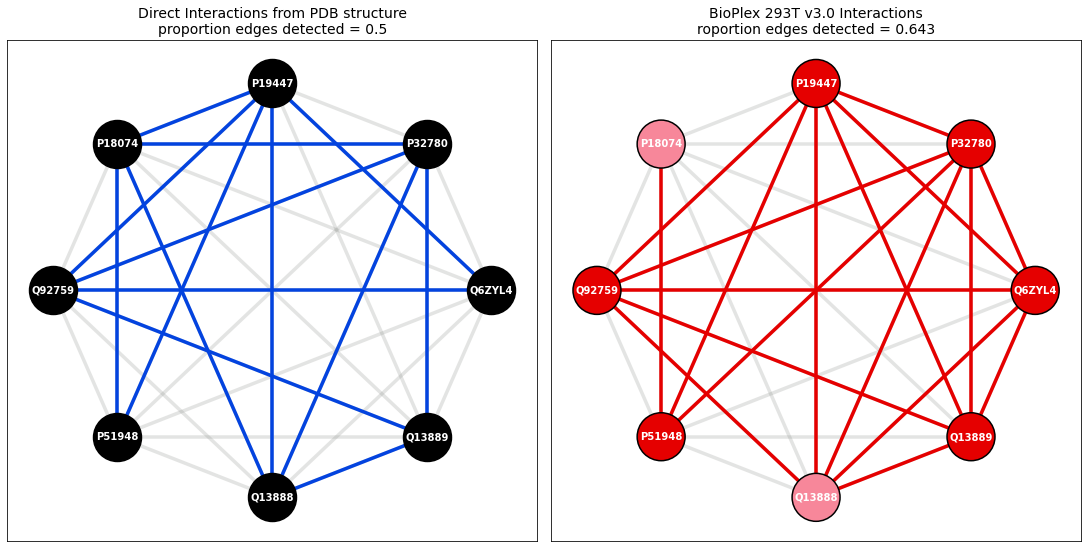

In [73]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig) # define 2 columns since we'll have two networks
spec.update(wspace=0.025) # set the spacing between axes

# chain/uniprot physical interaction network
ax1 = fig.add_subplot(spec[0])
node_layout_pdb, edges_list_pdb, num_possible_edges_pdb = display_PDB_network_for_complex(ax1, chain_to_UniProt_mapping_dict, interacting_UniProt_IDs, 2300, 3.5)
prop_edges_pdb = round(float(len(edges_list_pdb)) / num_possible_edges_pdb, 3)

# chain/uniprot PPI interaction network
ax2 = fig.add_subplot(spec[1])
bp_PPI_df = getBioPlex('293T', '3.0')
edges_list_bp, num_possible_edges_bp = display_PPI_network_match_PDB(ax2, chain_to_UniProt_mapping_dict, interacting_UniProt_IDs, bp_PPI_df, node_layout_pdb, 2300, 3.5)
prop_edges_bp = round(float(len(edges_list_bp)) / num_possible_edges_bp, 3)

# set titles
ax1.set_title(f'Direct Interactions from PDB structure\nproportion edges detected = {prop_edges_pdb}', color = 'black', fontsize = 14) # set title
ax2.set_title(f'BioPlex 293T v3.0 Interactions\nroportion edges detected = {prop_edges_bp}', color = 'black', fontsize = 14) # set title

fig = plt.gcf()
fig.set_size_inches(15, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_PDB_interaction_VS_293T_3.0_TFIIH-complex.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

Find the edges that are detected in both networks.

In [74]:
overlapping_edges_list = list(set(edges_list_pdb).intersection(set(edges_list_bp)))
overlapping_edges_list

[('Q92759', 'Q13889'),
 ('P18074', 'P51948'),
 ('P19447', 'Q92759'),
 ('P32780', 'Q13889'),
 ('P32780', 'Q92759'),
 ('Q6ZYL4', 'Q92759'),
 ('P19447', 'Q13888'),
 ('Q13888', 'Q13889'),
 ('P19447', 'P51948'),
 ('Q6ZYL4', 'P19447'),
 ('P32780', 'Q13888')]

Calculate proportion of edges that are detected in both networks.

In [75]:
round(float(len(overlapping_edges_list)) / num_possible_edges_pdb, 3)

0.393